## Feature Importance Cook Book
There are several ways to understand feature importance and contributions.  First a random forest model is build using the boston housing dataset.  

In [57]:
# Regression
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

boston = datasets.load_boston()
X, y = boston.data, boston.target
feature_names = boston.feature_names

# build a random forest models
model = RandomForestRegressor(n_estimators=5, min_samples_split=10)
model.fit(X, y)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Global Feature Importance
about sklearns feature importance calcuatlions

1.11.2.5. Feature importance evaluation 


"The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features. In scikit-learn, the fraction of samples a feature contributes to is combined with the decrease in impurity from splitting them to create a normalized estimate of the predictive power of that feature.

By averaging the estimates of predictive ability over several randomized trees one can reduce the variance of such an estimate and use it for feature selection. This is known as the mean decrease in impurity, or MDI. Refer to [L2014] for more information on MDI and feature importance evaluation with Random Forests. " 


#### Good plots have the following features
+ importance is highest on top and rank ordered
+ labels are readable, no more than 20


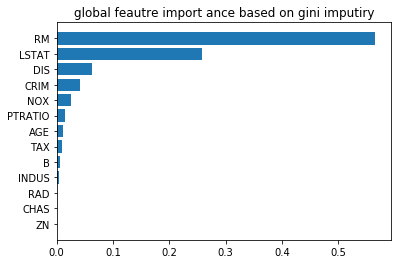

In [58]:
# global feature importance based on gini
imp = model.feature_importances_
index = np.argsort(imp)
plt.figure()
plt.barh(range(len(imp)), imp[index], tick_label=feature_names[index])
plt.title('global feautre import ance based on gini imputiry')
plt.show()


### Model Sensitivity to Specific Features
Models sensitivies can be estimated with the following code.  This essentially makes all features zero, and interates over an array of possible feature values. One draw back to this method is that tree models have specific regions where a specific features attribution may be different.  

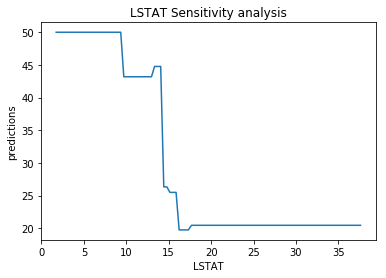

In [59]:


# plot sensitivity for one feature at a time with all other as zero
name = 'LSTAT'
index = [i for i, j in enumerate(feature_names) if j == name][0]
# get max and min values for the feature
max_val = max(X[:, index])
min_val = min(X[:, index])
# contstruct a new array
steps = 100
new_vals = np.arange(min_val, max_val, (max_val - min_val)/steps)

new_x = np.zeros((len(new_vals), X.shape[1]))
new_x[:, index] = new_vals

new_preds = model.predict(new_x)
plt.figure()
plt.plot(new_vals, new_preds)
plt.title(name + ' Sensitivity analysis')
plt.xlabel(name)
plt.ylabel('predictions')
plt.show()

### Feature Sensitivity Using means
To address the probelem of a feature have different attribution in different regions od the tree,
essentially, the tree can be centered at the medians or means. A nice enhancement is to add the feature histogram over the plot

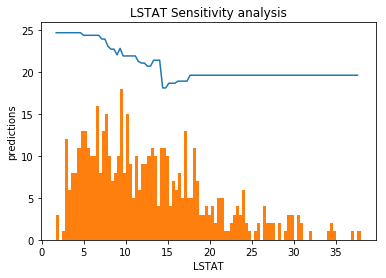

In [60]:

# sensitivity will all other feature at their means
# contstruct a new array
steps = 100

index = [i for i, j in enumerate(feature_names) if j == name][0]
# get max and min values for the feature
max_val = max(X[:, index])
min_val = min(X[:, index])
new_vals = np.arange(min_val, max_val, (max_val - min_val)/steps)
means = np.mean(X, axis=0)
for i, _ in enumerate(new_vals):
    if i == 0:
        new_x = means
    else:
        new_x = np.vstack((new_x, means))

new_x[:, index] = new_vals

new_preds = model.predict(new_x)

plt.plot(new_vals, new_preds)
plt.title(name + ' Sensitivity analysis')

plt.xlabel(name)
plt.ylabel('predictions')
plt.hist(X[:, index], bins =100)
plt.show()




### Decision Boundary
To estimate the interaction of two terms, and standard method is the decision bounday.  Essentally a meshgrid is setup with all possible value combinations between two varabiles, then predictions are made using the means of all the other varabiles. 

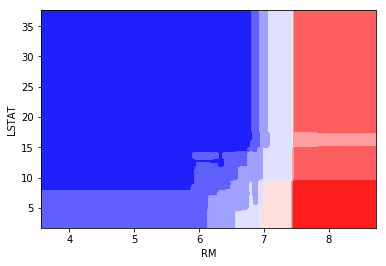

In [61]:
x_name = 'RM'
y_name = 'LSTAT'



index_x = [i for i, j in enumerate(feature_names) if j == x_name][0]
# get max and min values for the feature
max_val_x = max(X[:, index_x])
min_val_x = min(X[:, index_x])

index_y = [i for i, j in enumerate(feature_names) if j == y_name][0]
# get max and min values for the feature
max_val_y = max(X[:, index_y])
min_val_y = min(X[:, index_y])

# create a grid of every posible combination of xy 
steps = 100
new_x_vals = np.arange(min_val_x, max_val_x, (max_val_x - min_val_x)/steps)
new_y_vals = np.arange(min_val_y, max_val_y, (max_val_y - min_val_y)/steps)
xx, yy = np.meshgrid(new_x_vals, new_y_vals)


xx_rav = np.ravel(xx)
yy_rav = np.ravel(yy)


# sensitivity will all other feature at their means
# contstruct a new array
means = np.mean(X, axis=0)
for i, _ in enumerate(xx_rav):
    if i == 0:
        new_data = means
    else:
        new_data = np.vstack((new_data, means))

new_data[:, index_x] = xx_rav
new_data[:, index_y] = yy_rav

new_preds = np.reshape(model.predict(new_data), xx.shape)

plt.figure()
plt.contourf(xx, yy, new_preds,  cmap=plt.get_cmap('bwr'))
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.show()

#### Enhancements
It an easy enhancment to add a scatter plot of the actual points, color by the outcome

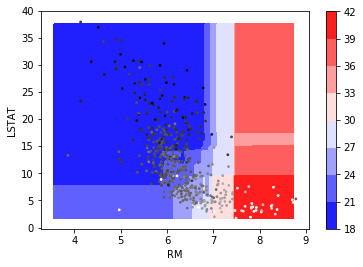

In [62]:
## plot new
x_new = X[:, index_x]
y_new = X[:,index_y]


plt.figure()
plt.contourf(xx, yy, new_preds,  cmap=plt.get_cmap('bwr'))
plt.colorbar()
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.scatter(x_new, y_new, c=y,s=3, cmap=plt.get_cmap('binary_r'))

plt.show()



### Using PCA TO Understand Over/ Underfitting
using principal compoent analysis, model over fitting and underfitting can be visualized,  leverage sklearn's PCA inverse transform 

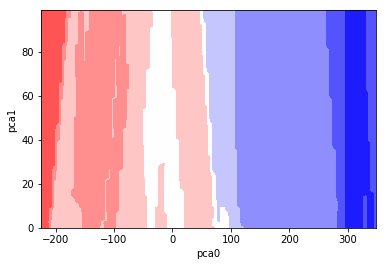

In [63]:
from sklearn.decomposition import PCA
p = PCA(2)
comps = p.fit_transform(X)

# get max and min values for the feature
max_val_x = max(comps[:,0])
min_val_x = min(comps[:, 0])

# get max and min values for the feature
max_val_y = max(X[:,1])
min_val_y = min(X[:, 1])

# create a grid of every posible combination of xy 
steps = 100
new_x_vals = np.arange(min_val_x, max_val_x, (max_val_x - min_val_x)/steps)
new_y_vals = np.arange(min_val_y, max_val_y, (max_val_y - min_val_y)/steps)
xx, yy = np.meshgrid(new_x_vals, new_y_vals)

xx_rav = np.ravel(xx)
yy_rav = np.ravel(yy)



new_data = p.inverse_transform(np.transpose(np.vstack((xx_rav, yy_rav))))

new_preds = np.reshape(model.predict(new_data), xx.shape)

plt.figure()
plt.contourf(xx, yy, new_preds,  cmap=plt.get_cmap('bwr'))
plt.xlabel('pca0')
plt.ylabel('pca1')
plt.show()